In [1]:
import re
import cftime 
import nc_time_axis

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import cmaps
from concurrent.futures import ProcessPoolExecutor

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
             
             
from src import nino34, precip, utils, cesm_utils

from shapely import geometry 
from scipy import stats 

from tqdm import tqdm

import random
random.seed(541415)

import warnings
warnings.filterwarnings('ignore')

import dask 
dask.config.set({"array.slicing.split_large_chunks": True})

%load_ext autoreload
%autoreload 2

In [2]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [3]:
# Open CESM2-LE data
N=13 # running mean correlation
def process_member(ens):
    print(f"Processing {ens}")
    monthly_sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.Nino34.nc")
    sst_anm = utils.get_model_sst_anomalies(monthly_sst_da, detrend=False)
    
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = utils.get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)

    print("Getting running correlation...")
    corr_lead = utils.get_running_corr(precip_anm, sst_anm.shift(time=1), window=N)
    
    return (corr_lead, precip_anm, sst_anm)
    
def main(members):
    lead_correlations = []
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        corr_lead, precip_anm, sst_anm = result
        lead_correlations.append(corr_lead)
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return lead_correlations, all_precips, all_ssts

lead_correlations, all_precips, all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009
Processing LE2-1181.010
Processing LE2-1231.002Processing LE2-1191.010Processing LE2-1231.001


Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.010
Processing LE2-1231.011
Processing LE2-1231.012
Processing LE2-1231.013
Processing LE2-1231.014
Processing LE2-1231.015
Processing LE2-1231.016
Processing LE2-1231.017
Processing LE2-1231.018Processing LE2-1231.019Processing LE2-1231.020


Processing LE2-1251.001Processing LE2-12

In [4]:
# Figure 2a
lead_correlations_da = xr.concat(lead_correlations, dim='ensemble')
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble')

In [5]:
# Figure 2b
precips_da_1900_2014 = precips_da.sel(time=slice('1900','2014'))
ssts_da_1900_2014 = ssts_da.sel(time=slice('1900','2014'))

years = list(range(1900, 2015))
num_samples = 10000

# Randomly select 10,000 13-year timeseries between 1900-2014
correlations = []
random_members = []
random_starts = []

for _ in range(num_samples):

    # Generate a random time index (0=1900, 102=2014-1900-13+1)
    random_time = random.randint(0, 102)

    # Generate a random member index (between 0 and 100)
    random_member = random.randint(0, 99)

    pre = precips_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
    st = ssts_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))

    corr = xr.corr(pre, st.shift(time=1), dim='time')

    correlations.append(corr.values.item())
    random_members.append(random_member)
    random_starts.append(years[random_time])

In [6]:
# Figure 2c and 2d
df = pd.DataFrame({'Correlations': correlations, 'Members': random_members, 'Years': random_starts})
df_sorted = df.sort_values(by=["Correlations"])

# Calculate quartiles
Q1 = df_sorted['Correlations'].quantile(0.25)
Q3 = df_sorted['Correlations'].quantile(0.75)

print(Q1)
print(Q3)

# Filter rows in the top quartile
top_quartile = df_sorted[df_sorted['Correlations'] >= Q3]
top_quartile = top_quartile.dropna()

# Filter rows in the bottom quartile
bottom_quartile = df_sorted[df_sorted['Correlations'] <= Q1]
bottom_quartile = bottom_quartile.dropna()

# Select top quartile and bottom quartile of correlations
df_neg = bottom_quartile
df_pos = top_quartile

print(df_pos.shape[0])
print(df_neg.shape[0])

df_random = df_sorted.sample(int(df_neg.shape[0]), random_state=541415) # since df_pos and df_neg have same shape, random has same shape

# For each ensemble member, get timeseries of global SST maps (previously saved in Figure3-Modeled Regression of SEAM on global SSTs)
def process_member(ens):
    print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc")
 
    return sst_da
    
def main(members):
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        sst_anm = result
        all_ssts.append(sst_anm)
    return all_ssts


# Call function
global_all_ssts = main(members)

# Concatenate
global_ssts_ds = xr.concat(global_all_ssts, dim='ensemble')

# Select only 1900-2015 (exclude future)
global_ssts_da = global_ssts_ds['SST'].isel(z_t=0, drop=True).sel(time=slice('1900-01','2014-12'))


-0.7713908293734361
-0.5627124976033004
2500
2500
Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009Processing LE2-1181.010

Processing LE2-1191.010
Processing LE2-1231.002Processing LE2-1231.001

Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006Processing LE2-1231.007

Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.010
Processing LE2-1231.011
Processing LE2-1231.012
Processing LE2-1231.014Processing LE2-1231.013Processing LE2-1231.015


Processing LE2-1231.016Processing LE2-1231.017Processing LE2-1231.018


Processing LE2-1231.020Processing LE2-

In [7]:
# For each of the three categories: positive correlations, negative correlations, and random, 
# select global SST slices 

def get_slices(ssts_da_norm):
    pos_sst_slices = []
    for index, row in df_pos.iterrows():
        ens = row['Members']
        year = row['Years']

        sst_ens = ssts_da_norm.isel(ensemble=int(ens))
        sst_slice = sst_ens.sel(time=slice(str(int(year)), str(int(year)+13))).mean(dim='time')

        pos_sst_slices.append(sst_slice)

    neg_sst_slices = []
    for index, row in df_neg.iterrows():
        ens = row['Members']
        year = row['Years']

        sst_ens = ssts_da_norm.isel(ensemble=int(ens))
        sst_slice = sst_ens.sel(time=slice(str(int(year)), str(int(year)+13))).mean(dim='time')

        neg_sst_slices.append(sst_slice)

    random_sst_slices = []
    for index, row in df_random.iterrows():
        ens = row['Members']
        year = row['Years']

        sst_ens = ssts_da_norm.isel(ensemble=int(ens))
        sst_slice = sst_ens.sel(time=slice(str(int(year)), str(int(year)+13))).mean(dim='time')

        random_sst_slices.append(sst_slice)

    return pos_sst_slices, neg_sst_slices, random_sst_slices

In [8]:
def draw_pdf(data, ax, xlabel, ylabel='Probability Density'):

    # Create the histogram with the 'viridis' colormap
    n, bins, patches = ax.hist(data, bins=35, linewidth=0.5, edgecolor='black', alpha=0.7, density=True)

    # Color each bar with the 'viridis' colormap
    for i, patch in enumerate(patches):
        plt.setp(patch, 'facecolor', 'grey')

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # Iterate over the patches to color the bottom and top quartiles
    for i in range(len(patches)):
        # Check if the current bin falls into the bottom or top quartile
        if bins[i] < q1:
            patches[i].set_facecolor('dodgerblue')
        if  bins[i+1] > q3:
            patches[i].set_facecolor('coral')

    legend_handles = [
        Patch(facecolor='dodgerblue', alpha=0.7, label='Lower Quartile \n (Correlated)'),
        Patch(facecolor='coral', alpha=0.7, label='Upper Quartile \n (Uncorrelated)')
    ]

    # Add legend to the plot
    ax.legend(handles=legend_handles, fontsize=6, frameon=False, loc='best')

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)

In [9]:
mpl.rcParams['hatch.linewidth'] = 0.4  # previous pdf hatch linewidth

def draw_sst_anomalies(data, ax, p_val, vmin=-.15, vmax=.15, ticks=[-.1, -.05, 0, 0.05, 0.1]):
    im = ax.contourf(
                    data.lon,
                    data.lat,
                    data,
                    cmap=cmaps.NCV_blu_red,
                    norm=mpl.colors.CenteredNorm(),
                    transform=ccrs.PlateCarree(),
                    extend="both",
                    levels=[-.10, -0.09, -.08, -0.07, -.06, -0.05, -.04,-0.03, -.02, -0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
                )

    sig = ax.contourf(
                    data.lon,
                    data.lat,
                    data.where(p_val<0.01),
                    cmap=cmaps.NCV_blu_red,
                    norm=mpl.colors.CenteredNorm(),
                    transform=ccrs.PlateCarree(),
                    extend="both",
                    hatches=['/////'],
                    levels=[-.10, -0.09, -.08, -0.07, -.06, -0.05, -.04,-0.03, -.02, -0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
                )

    ax.set_global()

    # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
    #geom = geometry.box(minx=40, maxx=80, miny=-5, maxy=5)
    #ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

    # Central: 100–125°E, -20°S–20°N)
    #geom = geometry.box(minx=100, maxx=125, miny=-20, maxy=20)
    #ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

    # Western Pacific: 5S-5N and 140E-180W.
    #geom = geometry.box(minx=140, maxx=360-180, miny=-5, maxy=5)
    #ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
        )
        
    return im
        

        




In [10]:
pos_sst_slices, neg_sst_slices, random_sst_slices = get_slices(global_ssts_da)

pos_sst_slices_da = xr.concat(pos_sst_slices, dim='random')
neg_sst_slices_da = xr.concat(neg_sst_slices, dim='random')

random_sst_slices_da = xr.concat(random_sst_slices, dim='random')

In [11]:
from statsmodels.stats.multitest import multipletests

def correct_pvals(p_val, alpha_global, method='fdr=bh'):

    p_values = p_val

    # Flatten array and remove NaNs
    p_values_flat = p_values.flatten()
    non_nan_mask = ~np.isnan(p_values_flat)
    non_nan_pvals = p_values_flat[non_nan_mask]

    # Apply the Benjamini-Hochberg correction
    _, corrected_pvals, _, _ = multipletests(non_nan_pvals, alpha=alpha_global, method=method)

    # Place corrected p-values back into the original array, keeping NaNs intact
    corrected_p_values = np.full_like(p_values_flat, np.nan)
    corrected_p_values[non_nan_mask] = corrected_pvals

    # Reshape back to the original shape
    corrected_p_values = corrected_p_values.reshape(p_values.shape)

    return corrected_p_values

In [12]:
# Upper Quartile
data1 = pos_sst_slices_da.mean(dim='random') - random_sst_slices_da.mean(dim='random')
t_stat1, p_val1 = stats.ttest_ind(pos_sst_slices_da, random_sst_slices_da, equal_var=False)
p_val1 = correct_pvals(p_val1, alpha_global=0.02, method='fdr_bh')

# Lower Quartile
data2 = neg_sst_slices_da.mean(dim='random') - random_sst_slices_da.mean(dim='random')
t_stat2, p_val2 = stats.ttest_ind(neg_sst_slices_da, random_sst_slices_da, equal_var=False)
p_val2 = correct_pvals(p_val2, alpha_global=0.02, method='fdr_bh')


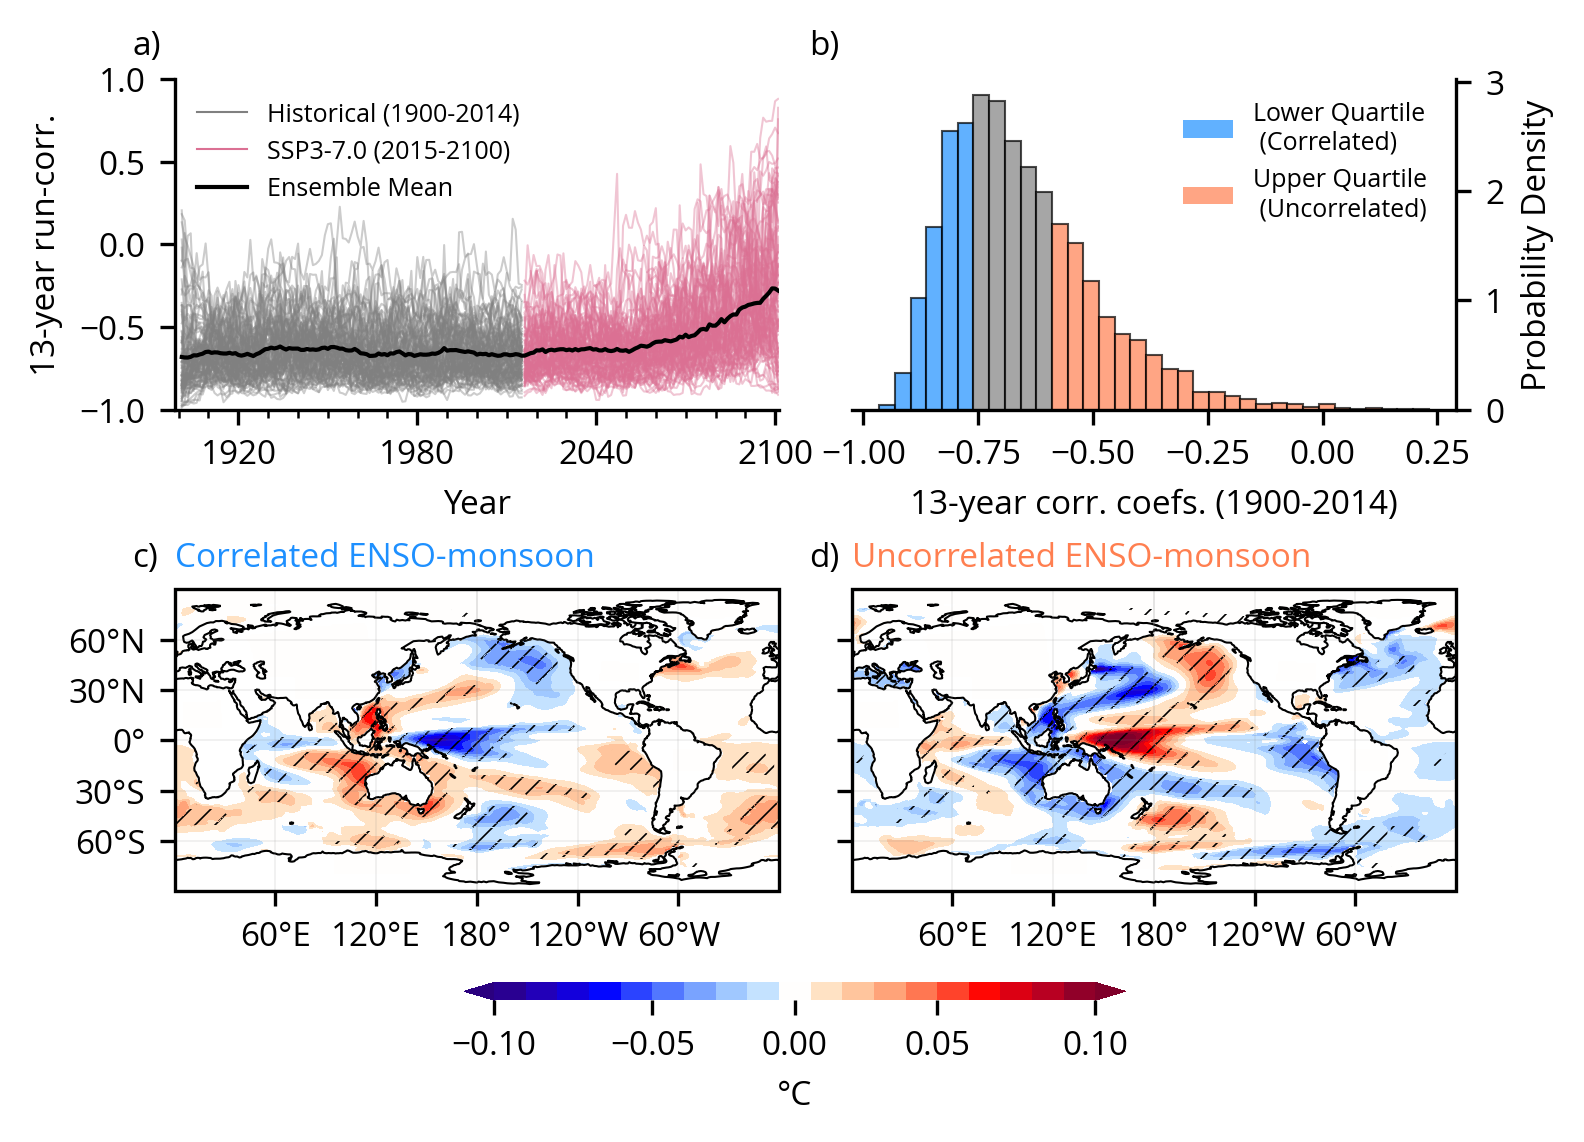

In [14]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 14
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 2, top=0.90, bottom=0.2, hspace=0.5, wspace=0.12)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 1a ##############
for ens in range(100):
    x = lead_correlations_da['corr'].isel(ensemble=ens)
    ax1.plot(
        x.time[:115],
        x.values[:115],
        linestyle='-',
        color='grey',
        alpha=0.4,
        linewidth=0.5,
    )
    ax1.plot(
        x.time[115:201],
        x.values[115:201],
        linestyle='-',
        color='palevioletred',
        alpha=0.4,
        linewidth=0.5,
    )

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ensemble_mean = lead_correlations_da['corr'].mean(dim='ensemble')
ax1.plot(
        ensemble_mean.time,
        ensemble_mean,
        label="Ensemble Mean",
        linestyle='-',
        color='k',
        alpha=1,
        linewidth=1
    )

line1 = Line2D([0], [0], color='grey', linewidth=0.5, linestyle='-')
line2 = Line2D([0], [0], color='palevioletred', linewidth=0.5, linestyle='-')
line3 = Line2D([0], [0], color='k', linewidth=1, linestyle='-')

plt.gca().add_patch(line1)
plt.gca().add_patch(line2)
plt.gca().add_patch(line3)

ax1.legend([line1, line2, line3], ['Historical (1900-2014)', 'SSP3-7.0 (2015-2100)', 'Ensemble Mean'], loc='upper left', frameon=False, fontsize=6)

line1.set_visible(False)
line2.set_visible(False)
line3.set_visible(False)

# Set x- and y- labels and axes
ax1.xaxis.set_minor_locator(mpl.dates.YearLocator(base=10))
ax1.set_xlim(-37000,37000)
ax1.set_ylim(-1,1)
ax1.set_ylabel("13-year run-corr.", fontsize=8)
ax1.set_xlabel("Year", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)  # Set tick params for ax1

############## Figure 1b ##############
data = correlations
xlabel = '13-year corr. coefs. (1900-2014)'
draw_pdf(data, ax2, xlabel)

ax2.yaxis.set_ticks_position('right')  # Set ticks to the right side
ax2.yaxis.set_label_position('right')  # Set the y-label to the right side
ax2.spines['top'].set_position(('axes', 1.0))  # Move right spine to right
ax2.spines['left'].set_color('none')  # Hide the left spine


############## Figure 1c ##############
data2.sel(lon=320, method='nearest')[:] = data2.sel(lon=321, method='nearest')
im = draw_sst_anomalies(data2, ax3, p_val2)
#ax3.spines['geo'].set_visible(False)
ax3.set_xticks([60, 120, 180, 240, 300],
                                crs=ccrs.PlateCarree())
ax3.set_xticklabels([60, 120, 180, 240, 300],fontsize=8)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax3.xaxis.set_major_formatter(lon_formatter)

ax3.set_yticks([-60, -30, 0, 30, 60], 
                                crs=ccrs.PlateCarree())
ax3.set_yticklabels([-60, -30, 0, 30, 60],fontsize=8)
lat_formatter = LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)

############## Figure 1d ##############
data1.sel(lon=320, method='nearest')[:] = data1.sel(lon=321, method='nearest')
im = draw_sst_anomalies(data1, ax4, p_val1)
#ax4.spines['geo'].set_visible(False)

ax4.set_xticks([60, 120, 180, 240, 300],
                                crs=ccrs.PlateCarree())
ax4.set_xticklabels([60, 120, 180, 240, 300],fontsize=8)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax4.xaxis.set_major_formatter(lon_formatter)

ax4.set_yticks([-60, -30, 0, 30, 60], 
                                crs=ccrs.PlateCarree())
ax4.set_yticklabels([])

# Set subplot labels
titles1 = ["a)", "b)", "c)", "d)"]
titles2 = [None, None, "Correlated ENSO-monsoon", "Uncorrelated ENSO-monsoon"]
colors = ['k', 'k', 'dodgerblue', 'coral']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3, ax4], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')


cbar_ax = fig.add_axes([0.3, 0.12, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-.1, -.05, 0, .05, .1], label="°C", orientation="horizontal", shrink=0.50)
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)

plt.savefig("Fig2.png")
